In [13]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
# hf_samples = lf_samples[::10]  # sample every 5 points
hf_samples = torch.linspace(0, 1, 21).reshape(-1, 1)
# add the end points
# hf_samples = torch.cat(
#     [torch.tensor([[0.0]]), hf_samples, torch.tensor([[0.93]]), torch.tensor([[0.975,]]), torch.tensor([[1.0]])], dim=0)

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)

In [15]:
# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

# dataset of lf1 and hf
responses_lf1 = {"lf": lf1_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf2 = {"lf": lf2_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf3 = {"lf": lf3_responses,
                 "hf": hf_responses}

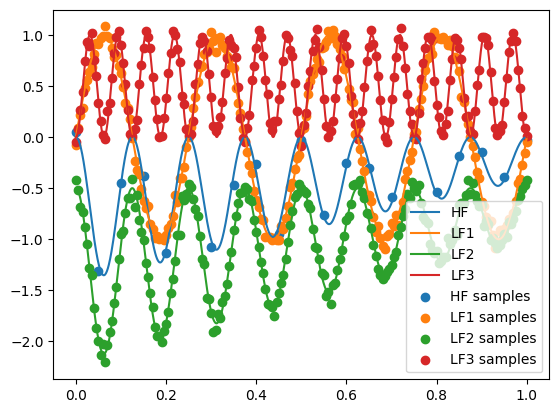

In [16]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless, label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless, label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless, label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
plt.legend()
plt.show()

In [17]:
# correlation between HF and LF samples
print("Correlation between HF and LF samples")
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf1_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf2_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf3_responses_noiseless.flatten()))

Correlation between HF and LF samples
PearsonRResult(statistic=-0.10188648995412593, pvalue=0.0012469388228371753)
PearsonRResult(statistic=0.9999999999999967, pvalue=0.0)
PearsonRResult(statistic=-0.0017524227898377388, pvalue=0.9558397582437065)


## Configurations for DNN and BNNs


In [18]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [40, 40],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [40, 40],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [19]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[40, 40],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

epoch:     0/20000
nll_loss: 797.017, prior_loss: 1638.767, total: 2435.784
noise: 0.123
epoch:   100/20000
nll_loss: 556.721, prior_loss: 1693.133, total: 2249.854
noise: 0.123
epoch:   200/20000
nll_loss: 550.010, prior_loss: 1737.732, total: 2287.742
noise: 0.123
epoch:   300/20000
nll_loss: 561.698, prior_loss: 1775.448, total: 2337.146
noise: 0.123
epoch:   400/20000
nll_loss: 548.187, prior_loss: 1822.896, total: 2371.083
noise: 0.123
epoch:   500/20000
nll_loss: 545.134, prior_loss: 1868.103, total: 2413.237
noise: 0.123
epoch:   600/20000
nll_loss: 541.020, prior_loss: 1920.288, total: 2461.308
noise: 0.123
epoch:   700/20000
nll_loss: 543.830, prior_loss: 1977.084, total: 2520.914
noise: 0.123
epoch:   800/20000
nll_loss: 543.160, prior_loss: 2013.186, total: 2556.346
noise: 0.123
epoch:   900/20000
nll_loss: 545.644, prior_loss: 2053.295, total: 2598.939
noise: 0.123
epoch:  1000/20000
nll_loss: 544.188, prior_loss: 2077.282, total: 2621.470
noise: 0.123
epoch:  1100/20000
nl

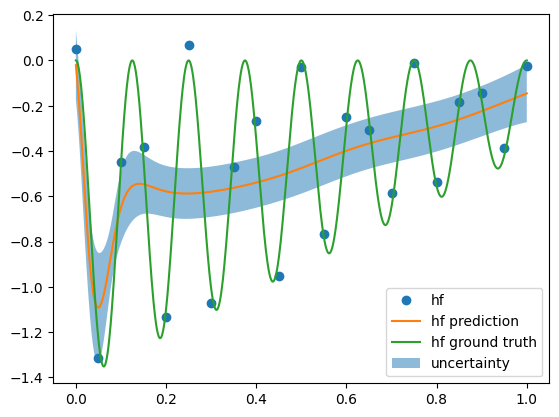

In [20]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [21]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9627074599266052
epoch:  200 train loss:  0.9622628092765808
epoch:  300 train loss:  0.9617988467216492
epoch:  400 train loss:  0.9611068367958069
epoch:  500 train loss:  0.9588264226913452
epoch:  600 train loss:  0.932572066783905
epoch:  700 train loss:  0.8663520812988281
epoch:  800 train loss:  0.7476586699485779
epoch:  900 train loss:  0.5919129848480225
epoch:  1000 train loss:  0.46848541498184204
epoch:  1100 train loss:  0.22619538009166718
epoch:  1200 train loss:  0.04707765951752663
epoch:  1300 train loss:  0.020108971744775772
epoch:  1400 train loss:  0.014951562508940697
epoch:  1500 train loss:  0.011830460280179977
epoch:  1600 train loss:  0.00953291542828083
epoch:  1700 train loss:  0.007882391102612019
epoch:  1800 train loss:  0.006830532103776932
epoch:  1900 train loss:  0.006199595984071493
epoch:  2000 train loss:  0.00580366887152195
epoch:  2100 train loss:  0.005527039524167776
epoch

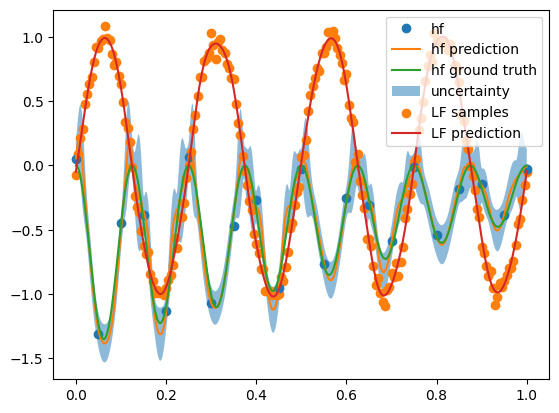

In [22]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [23]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9623520374298096
epoch:  200 train loss:  0.9619855880737305
epoch:  300 train loss:  0.9615321159362793
epoch:  400 train loss:  0.9602665901184082
epoch:  500 train loss:  0.9284288287162781
epoch:  600 train loss:  0.8363330960273743
epoch:  700 train loss:  0.6844925284385681
epoch:  800 train loss:  0.5428406000137329
epoch:  900 train loss:  0.37471601366996765
epoch:  1000 train loss:  0.16987471282482147
epoch:  1100 train loss:  0.06764820218086243
epoch:  1200 train loss:  0.02327636443078518


epoch:  1300 train loss:  0.016616012901067734
epoch:  1400 train loss:  0.013358557596802711
epoch:  1500 train loss:  0.011291248723864555
epoch:  1600 train loss:  0.009787702932953835
epoch:  1700 train loss:  0.008631548844277859
epoch:  1800 train loss:  0.007729510776698589
epoch:  1900 train loss:  0.00702745420858264
epoch:  2000 train loss:  0.006497066933661699
epoch:  2100 train loss:  0.0060567548498511314
epoch:  2200 train loss:  0.005726656876504421
epoch:  2300 train loss:  0.0054768165573477745
epoch:  2400 train loss:  0.005269767716526985
epoch:  2500 train loss:  0.005114806815981865
epoch:  2600 train loss:  0.004992090631276369
epoch:  2700 train loss:  0.004895490128546953
epoch:  2800 train loss:  0.0048188939690589905
epoch:  2900 train loss:  0.00482277711853385
epoch:  3000 train loss:  0.004707281943410635
epoch:  3100 train loss:  0.004680704791098833
epoch:  3200 train loss:  0.004633686505258083
epoch:  3300 train loss:  0.004605681635439396
epoch:  3400

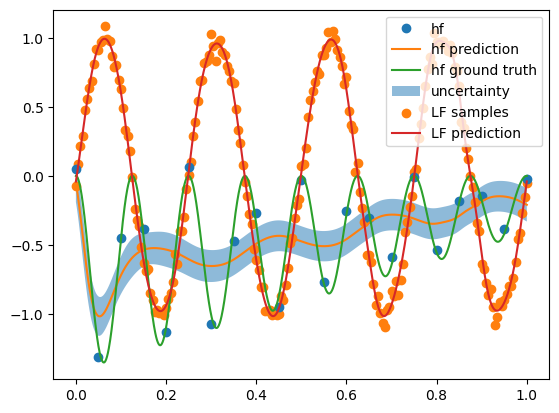

In [24]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

In [25]:
# mf-dnn-bnn with different orders
mfdnnbnn_lf1_order_2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure={
        "in_features": 1,
        "hidden_features": [50, 50],
        "out_features": 1,
        "activation": "Tanh",
        "lr": 0.01,
        "sigma": 0.05,
    },
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)

# train the model
mfdnnbnn_lf1_order_2.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config={
        "num_epochs": 30000,
        "sample_freq": 100,
        "print_info": True,
        "burn_in_epochs": 20000,
    },
)

No data split: use all data for training
epoch:  100 train loss:  0.9620459079742432
epoch:  200 train loss:  0.9615994691848755
epoch:  300 train loss:  0.9608308672904968
epoch:  400 train loss:  0.9568038582801819
epoch:  500 train loss:  0.893909752368927
epoch:  600 train loss:  0.8156912922859192
epoch:  700 train loss:  0.7401311993598938
epoch:  800 train loss:  0.36361342668533325
epoch:  900 train loss:  0.14206001162528992
epoch:  1000 train loss:  0.07473252713680267
epoch:  1100 train loss:  0.04181902855634689
epoch:  1200 train loss:  0.025816598907113075
epoch:  1300 train loss:  0.018153605982661247
epoch:  1400 train loss:  0.014283804222941399
epoch:  1500 train loss:  0.012100804597139359
epoch:  1600 train loss:  0.0105648934841156
epoch:  1700 train loss:  0.009017424657940865
epoch:  1800 train loss:  0.007701707538217306


epoch:  1900 train loss:  0.006822393741458654
epoch:  2000 train loss:  0.0062126959674060345
epoch:  2100 train loss:  0.0057664476335048676
epoch:  2200 train loss:  0.005446252413094044
epoch:  2300 train loss:  0.005201451946049929
epoch:  2400 train loss:  0.0051720403134822845
epoch:  2500 train loss:  0.004871767479926348
epoch:  2600 train loss:  0.004763519857078791
epoch:  2700 train loss:  0.004681271500885487
epoch:  2800 train loss:  0.004617874510586262
epoch:  2900 train loss:  0.00457005575299263
epoch:  3000 train loss:  0.004528161138296127
epoch:  3100 train loss:  0.004495658446103334
epoch:  3200 train loss:  0.004470351152122021
epoch:  3300 train loss:  0.004443743731826544
epoch:  3400 train loss:  0.00442311679944396
epoch:  3500 train loss:  0.004404534585773945
epoch:  3600 train loss:  0.004389228764921427
epoch:  3700 train loss:  0.004373755771666765
epoch:  3800 train loss:  0.004360849503427744
epoch:  3900 train loss:  0.004357979632914066
epoch:  4000

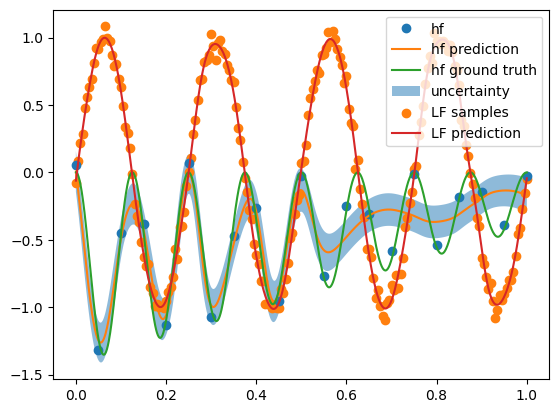

In [26]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_order_2_hy,
    mfdnnbnn_lf1_order_2_epistemic,
    mfdnnbnn_lf1_order_2_total_unc,
    mfdnnbnn_lf1_order_2_aleatoric,
) = mfdnnbnn_lf1_order_2.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_order_2_y = mfdnnbnn_lf1_order_2.predict_lf(
    x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(),
        mfdnnbnn_lf1_order_2_y,
        label="LF prediction")
ax.legend()
plt.show()

In [27]:
mfdnnbnn_lf1_order_2.beta

array([ 0.02759655, -0.07696766, -0.97327836])

## mf models for the second dataset

In [28]:
# sequential mf-bnn
smf_bnn_lf2 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8466666340827942
epoch:  200 train loss:  0.8462637662887573
epoch:  300 train loss:  0.8459775447845459
epoch:  400 train loss:  0.8457779884338379
epoch:  500 train loss:  0.8456188440322876
epoch:  600 train loss:  0.8454175591468811
epoch:  700 train loss:  0.8451166749000549
epoch:  800 train loss:  0.8446377515792847
epoch:  900 train loss:  0.8438054323196411
epoch:  1000 train loss:  0.8418911099433899
epoch:  1100 train loss:  0.8349230289459229
epoch:  1200 train loss:  0.804955244064331
epoch:  1300 train loss:  0.734110951423645
epoch:  1400 train loss:  0.6762686967849731
epoch:  1500 train loss:  0.6344276666641235
epoch:  1600 train loss:  0.5497097373008728
epoch:  1700 train loss:  0.5071849226951599
epoch:  1800 train loss:  0.46650201082229614
epoch:  1900 train loss:  0.39333149790763855
epoch:  2000 train loss:  0.3659818172454834
epoch:  2100 train loss:  0.35702210664749146
epoch:  2200 train los

epoch:  4100 train loss:  0.10776444524526596
epoch:  4200 train loss:  0.09982744604349136
epoch:  4300 train loss:  0.09294485300779343
epoch:  4400 train loss:  0.08838118612766266
epoch:  4500 train loss:  0.08556348830461502
epoch:  4600 train loss:  0.08261369168758392
epoch:  4700 train loss:  0.07943061739206314
epoch:  4800 train loss:  0.07464716583490372
epoch:  4900 train loss:  0.06915771216154099
epoch:  5000 train loss:  0.0646982416510582
epoch:  5100 train loss:  0.0614367239177227
epoch:  5200 train loss:  0.05903608351945877
epoch:  5300 train loss:  0.05660497769713402
epoch:  5400 train loss:  0.05302652716636658
epoch:  5500 train loss:  0.048346277326345444
epoch:  5600 train loss:  0.04443168640136719
epoch:  5700 train loss:  0.042084209620952606
epoch:  5800 train loss:  0.04090624302625656
epoch:  5900 train loss:  0.040190163999795914
epoch:  6000 train loss:  0.04314816743135452
epoch:  6100 train loss:  0.039362017065286636
epoch:  6200 train loss:  0.0389

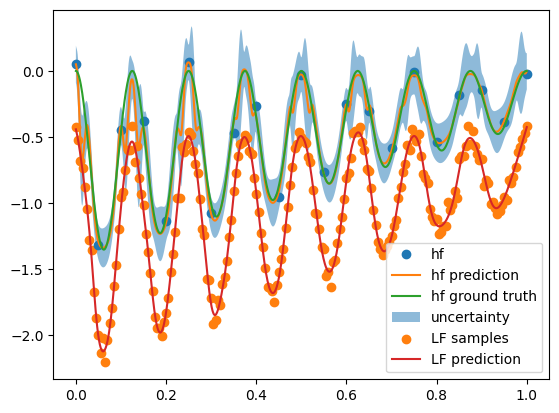

In [29]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf2_hy,
    smf_bnn_lf2_epistemic,
    smf_bnn_lf2_total_unc,
    smf_bnn_lf2_aleatoric,
) = smf_bnn_lf2.predict(x=test_samples)
# get lf predictions
smf_bnn_lf2_y = smf_bnn_lf2.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [30]:
# create the MFDNNBNN object
mfdnnbnn_lf2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8468295335769653
epoch:  200 train loss:  0.8465898036956787
epoch:  300 train loss:  0.8463686108589172
epoch:  400 train loss:  0.8461890816688538
epoch:  500 train loss:  0.8460562825202942
epoch:  600 train loss:  0.8459664583206177
epoch:  700 train loss:  0.8459030985832214
epoch:  800 train loss:  0.8458326458930969
epoch:  900 train loss:  0.8457200527191162
epoch:  1000 train loss:  0.8455016613006592
epoch:  1100 train loss:  0.8451696038246155
epoch:  1200 train loss:  0.8447874188423157
epoch:  1300 train loss:  0.8443636298179626
epoch:  1400 train loss:  0.843915581703186


epoch:  1500 train loss:  0.8434484004974365
epoch:  1600 train loss:  0.8428472280502319
epoch:  1700 train loss:  0.8414990901947021
epoch:  1800 train loss:  0.8371620774269104
epoch:  1900 train loss:  0.7864004969596863
epoch:  2000 train loss:  0.6976901888847351
epoch:  2100 train loss:  0.6720889806747437
epoch:  2200 train loss:  0.6602327823638916
epoch:  2300 train loss:  0.6437013745307922
epoch:  2400 train loss:  0.5784968137741089
epoch:  2500 train loss:  0.525679349899292
epoch:  2600 train loss:  0.503836989402771
epoch:  2700 train loss:  0.46968400478363037
epoch:  2800 train loss:  0.40945979952812195
epoch:  2900 train loss:  0.3725983202457428
epoch:  3000 train loss:  0.3517284095287323
epoch:  3100 train loss:  0.3192155659198761
epoch:  3200 train loss:  0.292463481426239
epoch:  3300 train loss:  0.26262155175209045
epoch:  3400 train loss:  0.24693939089775085
epoch:  3500 train loss:  0.2412981390953064
epoch:  3600 train loss:  0.23735082149505615
epoch:  

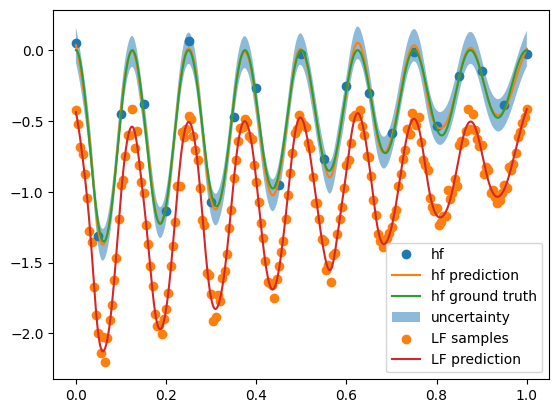

In [31]:
(
    hy_proposed_lf2,
    epistemic_proposed_lf2,
    total_unc_proposed_lf2,
    aleatoric_proposed_lf2,
) = mfdnnbnn_lf2.predict(x=test_samples)
# lf prediction
lf2_y_proposed = mfdnnbnn_lf2.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf2_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

## for datset 3

In [32]:
# sequential mf-bnn
smf_bnn_lf3 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.995198130607605
epoch:  200 train loss:  0.9951192140579224
epoch:  300 train loss:  0.9950291514396667
epoch:  400 train loss:  0.9949302077293396
epoch:  500 train loss:  0.9948244094848633
epoch:  600 train loss:  0.994720458984375
epoch:  700 train loss:  0.9946317672729492
epoch:  800 train loss:  0.9945592284202576
epoch:  900 train loss:  0.9943963289260864
epoch:  1000 train loss:  0.9939908385276794
epoch:  1100 train loss:  0.9932717084884644
epoch:  1200 train loss:  0.9920678734779358
epoch:  1300 train loss:  0.989905834197998
epoch:  1400 train loss:  0.9857441186904907
epoch:  1500 train loss:  0.9783188700675964
epoch:  1600 train loss:  0.9659587144851685
epoch:  1700 train loss:  0.953509509563446
epoch:  1800 train loss:  0.944623589515686
epoch:  1900 train loss:  0.935219407081604
epoch:  2000 train loss:  0.9243200421333313
epoch:  2100 train loss:  0.9122558236122131
epoch:  2200 train loss:  0.8

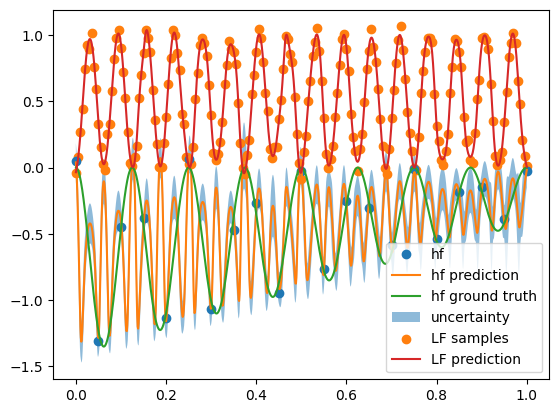

In [33]:
# plot
(
    smf_bnn_lf3_hy,
    smf_bnn_lf3_epistemic,
    smf_bnn_lf3_total_unc,
    smf_bnn_lf3_aleatoric,
) = smf_bnn_lf3.predict(x=test_samples)
# get lf predictions
smf_bnn_lf3_y = smf_bnn_lf3.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [34]:
# create the MFDNNBNN object
mfdnnbnn_lf3 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9948103427886963
epoch:  200 train loss:  0.994628369808197
epoch:  300 train loss:  0.9945995211601257
epoch:  400 train loss:  0.9945884346961975
epoch:  500 train loss:  0.9945752620697021
epoch:  600 train loss:  0.9945563077926636
epoch:  700 train loss:  0.9945043921470642
epoch:  800 train loss:  0.9943187236785889
epoch:  900 train loss:  0.9938294291496277
epoch:  1000 train loss:  0.992973804473877
epoch:  1100 train loss:  0.9914177060127258
epoch:  1200 train loss:  0.9883958697319031


epoch:  1300 train loss:  0.9834862947463989
epoch:  1400 train loss:  0.97783362865448
epoch:  1500 train loss:  0.9722545742988586
epoch:  1600 train loss:  0.9655028581619263
epoch:  1700 train loss:  0.9575697779655457
epoch:  1800 train loss:  0.9501830339431763
epoch:  1900 train loss:  0.9420642852783203
epoch:  2000 train loss:  0.9312965869903564
epoch:  2100 train loss:  0.9223741888999939
epoch:  2200 train loss:  0.9165431261062622
epoch:  2300 train loss:  0.9122606515884399
epoch:  2400 train loss:  0.9072678685188293
epoch:  2500 train loss:  0.8997834324836731
epoch:  2600 train loss:  0.8921836614608765
epoch:  2700 train loss:  0.8860626816749573
epoch:  2800 train loss:  0.880653977394104
epoch:  2900 train loss:  0.8744542598724365
epoch:  3000 train loss:  0.8646801710128784
epoch:  3100 train loss:  0.8471304178237915
epoch:  3200 train loss:  0.8300309181213379
epoch:  3300 train loss:  0.8224790692329407
epoch:  3400 train loss:  0.8185054063796997
epoch:  3500 

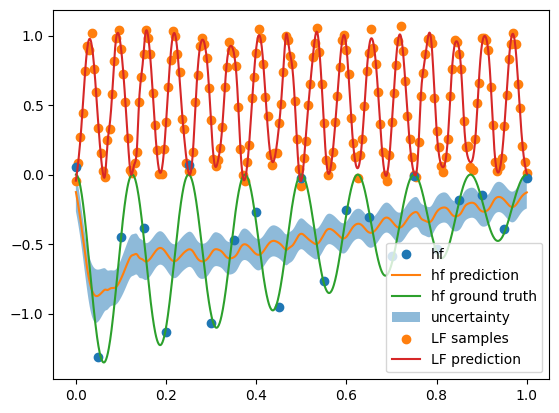

In [35]:
# predict
(
    hy_proposed_lf3,
    epistemic_proposed_lf3,
    total_unc_proposed_lf3,
    aleatoric_proposed_lf3,
) = mfdnnbnn_lf3.predict(x=test_samples)
# lf prediction
lf3_y_proposed = mfdnnbnn_lf3.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf3_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [36]:
# print the beta values
print("Beta values")
print(mfdnnbnn_lf1.beta)
print(mfdnnbnn_lf1_order_2.beta)
print(mfdnnbnn_lf2.beta)
print(mfdnnbnn_lf3.beta)

Beta values
[-0.43559929 -0.07273315]
[ 0.02759655 -0.07696766 -0.97327836]
[0.42649832 0.84838372]
[-0.39322509 -0.08939246]


In [37]:
# evaluate the models on the accuracy metrics
# bnn model
# calculate the mse
import pandas as pd
bnn_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), bnn_y, bnn_total_unc)
bnn_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), bnn_y)
# print the results
print("BNN model")
print(f"Normalized RMSE: {bnn_mse}")
print(f"Normalized MAE: {bnn_nmae}")
print(f"Normalized Log Likelihood: {bnn_nll}")
print(f"R2: {bnn_r2}")

# sequential mf-bnn on lf1
# calculate the mse
smf_bnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy, smf_bnn_lf1_total_unc)
smf_bnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
# print the results
print("Sequential MF-BNN on LF1")
print(f"Normalized RMSE: {smf_bnn_lf1_mse}")
print(f"Normalized MAE: {smf_bnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf1_nll}")
print(f"R2: {smf_bnn_lf1_r2}")

# mf-dnn-bnn on lf1
# calculate the mse
mfdnnbnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy, mfdnnbnn_lf1_total_unc)
mfdnnbnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
# print the results
print("MF-DNN-BNN on LF1")
print(f"Normalized RMSE: {mfdnnbnn_lf1_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_nll}")

# mf-dnn-bnn on lf1 with order 2
# calculate the mse
mfdnnbnn_lf1_order_2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy, mfdnnbnn_lf1_order_2_total_unc)
mfdnnbnn_lf1_order_2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
# print the results
print("MF-DNN-BNN on LF1 with order 2")
print(f"Normalized RMSE: {mfdnnbnn_lf1_order_2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_order_2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_order_2_nll}")
print(f"R2: {mfdnnbnn_lf1_order_2_r2}")


# sequential mf-bnn on lf2
# calculate the mse
smf_bnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy, smf_bnn_lf2_total_unc)
smf_bnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
# print the results
print("Sequential MF-BNN on LF2")
print(f"Normalized RMSE: {smf_bnn_lf2_mse}")
print(f"Normalized MAE: {smf_bnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf2_nll}")
print(f"R2: {smf_bnn_lf2_r2}")

# mf-dnn-bnn on lf2
# calculate the mse
mfdnnbnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2, total_unc_proposed_lf2)
mfdnnbnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
# print the results
print("MF-DNN-BNN on LF2")
print(f"Normalized RMSE: {mfdnnbnn_lf2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf2_nll}")
print(f"R2: {mfdnnbnn_lf2_r2}")

# sequential mf-bnn on lf3
# calculate the mse
smf_bnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy, smf_bnn_lf3_total_unc)
smf_bnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)

# print the results
print("Sequential MF-BNN on LF3")
print(f"Normalized RMSE: {smf_bnn_lf3_mse}")
print(f"Normalized MAE: {smf_bnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf3_nll}")
print(f"R2: {smf_bnn_lf3_r2}")

# mf-dnn-bnn on lf3
# calculate the mse
mfdnnbnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3, total_unc_proposed_lf3)
mfdnnbnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
# print the results
print("MF-DNN-BNN on LF3")
print(f"Normalized RMSE: {mfdnnbnn_lf3_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf3_nll}")
print(f"R2: {mfdnnbnn_lf3_r2}")

# save the results in pandas dataframe
results = {
    "Model": ["BNN", "Sequential MF-BNN LF1", "MF-DNN-BNN LF1",
              "MF-DNN-BNN LF1 Order 2", "Sequential MF-BNN LF2",
              "MF-DNN-BNN LF2", "Sequential MF-BNN LF3", "MF-DNN-BNN LF3"],
    "Normalized RMSE": [bnn_mse, smf_bnn_lf1_mse, mfdnnbnn_lf1_mse,
                        mfdnnbnn_lf1_order_2_mse, smf_bnn_lf2_mse,
                        mfdnnbnn_lf2_mse, smf_bnn_lf3_mse, mfdnnbnn_lf3_mse],
    "Normalized MAE": [bnn_nmae, smf_bnn_lf1_nmae, mfdnnbnn_lf1_nmae,
                       mfdnnbnn_lf1_order_2_nmae, smf_bnn_lf2_nmae,
                       mfdnnbnn_lf2_nmae, smf_bnn_lf3_nmae, mfdnnbnn_lf3_nmae],
    "Normalized Log Likelihood": [bnn_nll, smf_bnn_lf1_nll, mfdnnbnn_lf1_nll,
                                  mfdnnbnn_lf1_order_2_nll, smf_bnn_lf2_nll,
                                  mfdnnbnn_lf2_nll, smf_bnn_lf3_nll, mfdnnbnn_lf3_nll],
    "R2": [bnn_r2, smf_bnn_lf1_r2, mfdnnbnn_lf1_r2,
           mfdnnbnn_lf1_order_2_r2, smf_bnn_lf2_r2,
           mfdnnbnn_lf2_r2, smf_bnn_lf3_r2, mfdnnbnn_lf3_r2],
}
results_df = pd.DataFrame(results)
print(results_df)
# save the results
results_df.to_csv("results.csv", index=False)

BNN model
Normalized RMSE: 0.6799835562705994
Normalized MAE: 1.4355238676071167
Normalized Log Likelihood: -12.245838165283203
R2: 0.28802734388077456
Sequential MF-BNN on LF1
Normalized RMSE: 0.16732889413833618
Normalized MAE: 0.5518081188201904
Normalized Log Likelihood: 1.180635690689087
R2: 0.9568869925581956
MF-DNN-BNN on LF1
Normalized RMSE: 0.699959933757782
Normalized MAE: 1.5348111391067505
Normalized Log Likelihood: -12.758049964904785
MF-DNN-BNN on LF1 with order 2
Normalized RMSE: 0.4056280553340912
Normalized MAE: 0.9870965480804443
Normalized Log Likelihood: -2.386005401611328
R2: 0.7466491055343576
Sequential MF-BNN on LF2
Normalized RMSE: 0.20699240267276764
Normalized MAE: 1.150913953781128
Normalized Log Likelihood: 1.2875423431396484
R2: 0.9340256194776718
MF-DNN-BNN on LF2
Normalized RMSE: 0.05778415501117706
Normalized MAE: 0.1308547705411911
Normalized Log Likelihood: 1.846445918083191
R2: 0.9948585684810636
Sequential MF-BNN on LF3
Normalized RMSE: 0.9304530024

In [38]:
results_df

,Model,Normalized RMSE,Normalized MAE,Normalized Log Likelihood,R2
0,BNN,0.679984,1.435524,-12.245838,0.288027
1,Sequential MF-BNN LF1,0.167329,0.551808,1.180636,0.956887
2,MF-DNN-BNN LF1,0.699960,1.534811,-12.758050,0.245581
3,MF-DNN-BNN LF1 Order 2,0.405628,0.987097,-2.386005,0.746649
4,Sequential MF-BNN LF2,0.206992,1.150914,1.287542,0.934026
5,MF-DNN-BNN LF2,0.057784,0.130855,1.846446,0.994859
6,Sequential MF-BNN LF3,0.930453,2.845648,-11.584419,-0.333077
7,MF-DNN-BNN LF3,0.702931,1.531206,-12.486236,0.239163


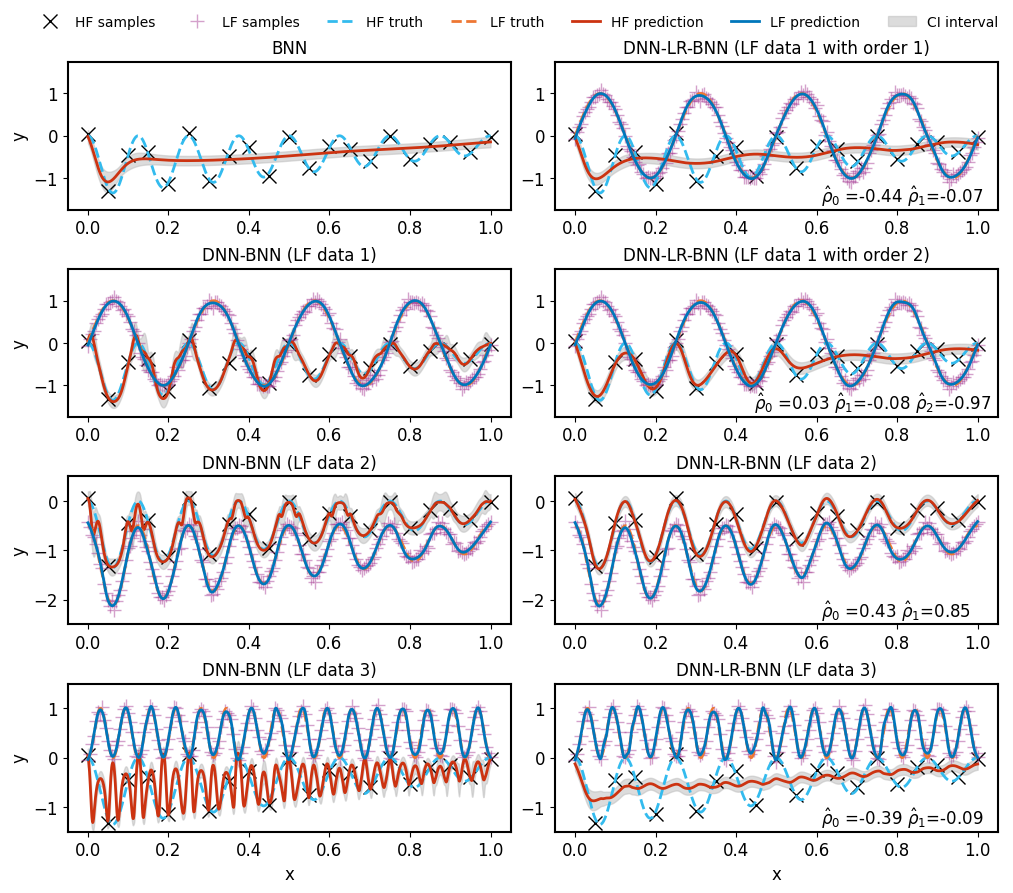

In [68]:
# plot the prediction of the models into one figure where the first row is the
# prediction of bnn (with one subfigure), and the second row is the prediction of sequential mf-bnn mf-dnn-bnn on lf1 (with two subfigures)
# the third row is the prediction of sequential mf-bnn mf-dnn-bnn on lf2 (with two subfigures)
# the forth row is the prediction of sequential mf-bnn mf-dnn-bnn on lf3  (with two subfigures)
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
# plot the prediction of bnn
axs[0, 0].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10, label="HF samples")
axs[0, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[0, 0].plot(test_samples.numpy(),
               bnn_y,
               "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)

axs[0, 0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[0, 0].legend()
axs[0, 0].set_title("BNN")

# plot the prediction of mf-dnn-bnn on lf1 with order1
axs[0, 1].plot(hf_samples, hf_responses, "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[0, 1].plot(lf_samples, lf1_responses,
               "+", color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[0, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# plot the lf truth
axs[0, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[0, 1].plot(test_samples.numpy(),
               mfdnnbnn_lf1_hy,  "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)
axs[0, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_order_2_y,
    "-", color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
axs[0, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[0, 1].legend()
axs[0, 1].set_title("DNN-LR-BNN (LF data 1 with order 1)")


# plot the prediction of sequential mf-bnn on lf1
axs[1, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[1, 0].plot(lf_samples, lf1_responses,  '+',
               color="#AA4499",
               linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[1, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[1, 0].plot(test_samples.numpy(), smf_bnn_lf1_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[1, 0].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
#
axs[1, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,

    label="LF prediction"
)
axs[1, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 0].legend()
axs[1, 0].set_title("DNN-BNN (LF data 1)")


# plot the prediction of mf-dnn-bnn on lf1
axs[1, 1].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10,
               label="HF samples")
axs[1, 1].plot(lf_samples, lf1_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[1, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# with lf order 2
axs[1, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[1, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[1, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# with lf order 2
axs[1, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 1].legend()
axs[1, 1].set_title("DNN-LR-BNN (LF data 1 with order 2)")
# plot the prediction of sequential mf-bnn on lf2
axs[2, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[2, 0].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)


axs[2, 0].plot(test_samples.numpy(), smf_bnn_lf2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[2, 0].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[2, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[2, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf2_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[2, 0].legend()
axs[2, 0].set_title("DNN-BNN (LF data 2)")

# plot the prediction of mf-dnn-bnn on lf2
axs[2, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[2, 1].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[2, 1].plot(test_samples.numpy(), hy_proposed_lf2,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[2, 1].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
# plot the lf prediction
axs[2, 1].plot(
    test_samples.numpy(),
    lf2_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# plot the uncertainty
axs[2, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval"
)

# axs[2, 1].legend()
axs[2, 1].set_title("DNN-LR-BNN (LF data 2)")
# plot the prediction of sequential mf-bnn on lf3
axs[3, 0].plot(hf_samples, hf_responses,
               'kx', linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 0].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 0].plot(test_samples.numpy(), smf_bnn_lf3_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")

# plot the lf truth
axs[3, 0].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[3, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"

)

axs[3, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[3, 0].legend()
axs[3, 0].set_title("DNN-BNN (LF data 3)")

# plot the prediction of mf-dnn-bnn on lf3
axs[3, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 1].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 1].plot(test_samples.numpy(), hy_proposed_lf3,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")


# plot the lf truth
axs[3, 1].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
axs[3, 1].plot(
    test_samples.numpy(),
    lf3_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[3, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[3, 1].legend()
axs[3, 1].set_title("DNN-LR-BNN (LF data 3)")
# set the axis labels x for the bottom row and y for the left column
for ii in range(4):
    for jj in range(2):
        if ii == 3:
            axs[ii, jj].set_xlabel("x", fontsize=12)
        if jj == 0:
            axs[ii, jj].set_ylabel("y", fontsize=12)
# set the line width of the axes
for ii in range(4):
    for jj in range(2):
        axs[ii, jj].spines["top"].set_linewidth(1.5)
        axs[ii, jj].spines["right"].set_linewidth(1.5)
        axs[ii, jj].spines["left"].set_linewidth(1.5)
        axs[ii, jj].spines["bottom"].set_linewidth(1.5)
        # font size of the axis
        axs[ii, jj].tick_params(axis="both", which="major", labelsize=12)

# set the limit of y for each row

for jj in range(2):
    axs[0, jj].set_ylim([-1.75, 1.75])
    axs[1, jj].set_ylim([-1.75, 1.75])
    axs[2, jj].set_ylim([-2.5, 0.5])
    axs[3, jj].set_ylim([-1.5, 1.5])
# set legende for the first subfigure  and put it outside the figure
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.2, 1.4), fontsize=10,
                 frameon=False, ncol=47)

# add beta values to the right subfigures
axs[0, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf1.beta[0].item(), mfdnnbnn_lf1.beta[1].item()),
    fontsize=12,
    transform=axs[0, 1].transAxes)
axs[1, 1].text(0.45, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f} $\hat \rho_2$={:0.2f}" .format(
    mfdnnbnn_lf1_order_2.beta[0].item(), mfdnnbnn_lf1_order_2.beta[1].item(), mfdnnbnn_lf1_order_2.beta[2].item()),
    fontsize=12,
    transform=axs[1, 1].transAxes)
axs[2, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf2.beta[0].item(), mfdnnbnn_lf2.beta[1].item()),
    fontsize=12,
    transform=axs[2, 1].transAxes)
axs[3, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf3.beta[0].item(), mfdnnbnn_lf3.beta[1].item()),
    fontsize=12,
    transform=axs[3, 1].transAxes)

# space of sub-figures
plt.subplots_adjust(wspace=0.1, hspace=0.4)
# save
plt.savefig("mf_dnn_bnn_known_noise.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.svg", bbox_inches="tight", dpi=300)
plt.show()